# DC$\pi$BO - Non-stationary SCM and DAG (NONSTAT, i.e. edges X0->Z1, Z1->Y2)

## Imports

In [113]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../..")

from src.examples.example_setups import setup_nonstat_scm

from src.utils.sem_utils.toy_sems import NonStationaryDependentSEM as NonStatSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat
from src.utils.plotting import plot_expected_opt_curve_paper
from src.utils.utility_functions import *

from src.experimental.experiments_nonstat import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial

from src.methods.bo_nonstat import BO
from src.methods.dcbo_nonstat import DCBO
from src.methods.pibo_nonstat import PIBO
from src.methods.dcpibo_nonstat import DCPIBO

from matplotlib.pyplot import rc
import numpy as np
from scipy import stats
import random

random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants and such

In [114]:
T = 3
t_axis = np.linspace(1,T,T,dtype=int)
N = 10
std = 0.1
beta = 1

## Setup

### Model:

In [115]:
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, all_causal_effects = setup_nonstat_scm(T=T)

In [116]:
G.add_edge('X_0','Z_1')
G.add_edge('Z_1','Y_2')

0

### Good prior

In [117]:
y=true_objective_values

In [118]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates, N, beta)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

### Bad prior

In [119]:
bad_y=[x/3 for x in true_objective_values]

In [120]:
bad_all_variates, bad_all_amps, bad_all_pdfs = compute_statistics(bad_y, std)
bad_all_variates_regret = regret_priors(bad_all_variates, N, beta)

bad_all_pdfs_normalised = normalise_pdfs(bad_all_pdfs)

bad_predicted_optima_regret = predict_optima_regret(N, T, bad_all_variates_regret, bad_all_pdfs_normalised) # this are all the 𝜋s

### *Very* bad prior

In [121]:
# very_bad_y = np.random.randint(-abs(max(true_objective_values)), abs(max(true_objective_values)), T)

In [122]:
# very_bad_all_variates, very_bad_all_amps, very_bad_all_pdfs = compute_statistics(very_bad_y, std)
# very_bad_all_variates_regret = regret_priors(very_bad_all_variates, N, beta)

# very_bad_all_pdfs_normalised = normalise_pdfs(very_bad_all_pdfs)

# very_bad_predicted_optima_regret = predict_optima_regret(N, T, very_bad_all_variates_regret, very_bad_all_pdfs_normalised) # this are all the 𝜋s

## Models' executions

In [123]:
change_points = T*[False]
change_points[1] = True # We encode where the time-series changes stationary regime
R = 3

### Good prior

In [124]:
good_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.95it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.20it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.01it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.75it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.28it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.11it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.21s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:08<00:04,  4.66s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.16s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:08<00:04,  4.65s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  33%|██████████████████████▎           


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.92it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.55it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.51it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.55it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.71it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.49it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.11s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:04,  4.84s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.48s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:05,  5.05s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  67%|██████████████████████████████████


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.44it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.19it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.21it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.05it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.99it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.87it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.32s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:05,  5.02s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.34s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:05,  5.12s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count: 100%|██████████████████████████████████

### Bad prior

In [159]:
bad_results = run_methods_replicates(G=G, 
                                sem=NonStatSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = None,
                                exploration_sets = exploration_sets,
                                priors_regret = bad_predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 10, # The method samples 10 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                change_points=change_points)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.29it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.61it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.69it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.19it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.97it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.80it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:07,  3.85s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:10<00:05,  5.47s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.33s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:04,  4.94s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  33%|██████████████████████▎           


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.56it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.53it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.97it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.77it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  6.13it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.98it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.35s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:04,  4.90s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:06,  3.14s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:08<00:04,  4.71s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count:  67%|██████████████████████████████████


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  5.69it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.97it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.90it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  6.69it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  5.93it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.64it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:07,  3.75s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:09<00:05,  5.12s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index: 100%|████████████████████████████████████████


	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/sem_utils/toy_sems.py:180: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:03<00:07,  3.65s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:10<00:05,  5.36s/it]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Experiment count: 100%|██████████████████████████████████

### *Very* bad prior

In [126]:
# very_bad_results = run_methods_replicates(G=G, 
#                                 sem=NonStatSEM, 
#                                 make_sem_estimator=build_sem_hat, 
#                                 base_target_variable='Y',
#                                 intervention_domain = intervention_domain, 
#                                 methods_list = ['BO', 'PIBO', 'DCBO', 'DCPIBO'],
#                                 obs_samples = None,
#                                 exploration_sets = exploration_sets,
#                                 priors_regret = very_bad_predicted_optima_regret,
#                                 total_timesteps = T,
#                                 number_of_trials = N, 
#                                 reps = R, # Number of replicates (how many times we run each method)
#                                 n_restart = 1,
#                                 save_data = False,
#                                 n_obs = 10, # The method samples 10 time-series for each replicate
#                                 num_anchor_points = 100,
#                                 sample_anchor_points = True,
#                                 controlled_experiment=False,
#                                 change_points=change_points)

## Plotting

In [127]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

### Good prior

In [128]:
good_data = get_relevant_results(results=good_results, replicates=R)
good_exp_optimal_outcome_values_during_trials, good_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=good_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

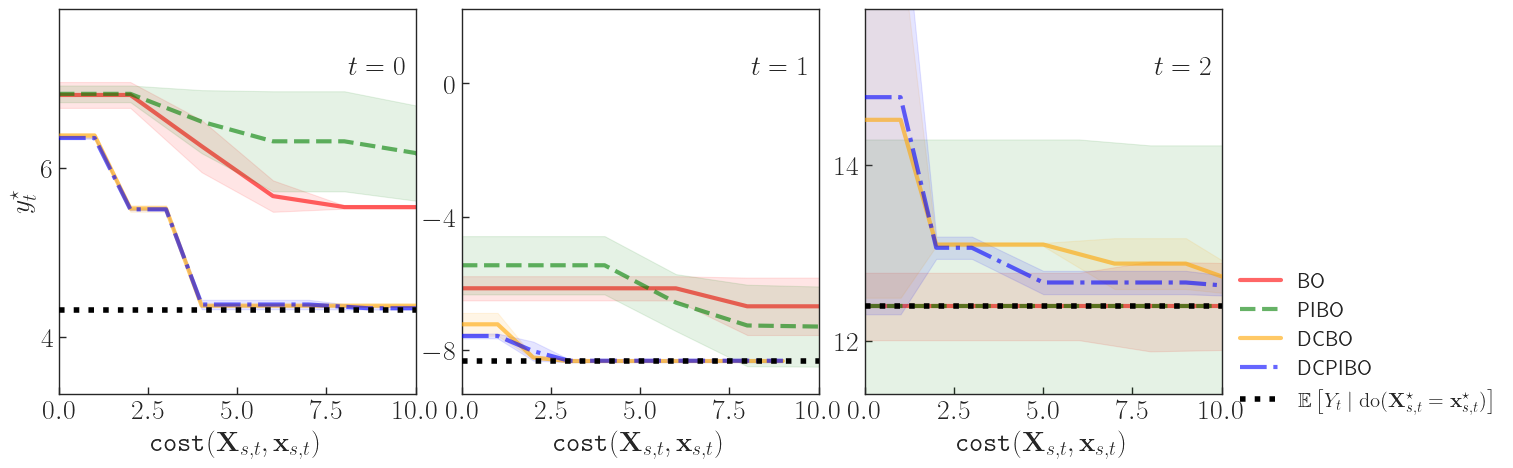

In [129]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    good_exp_per_trial_cost,
    good_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Bad prior

In [160]:
bad_data = get_relevant_results(results=bad_results,replicates=R)
bad_exp_optimal_outcome_values_during_trials, bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
                                                                         n_replicates=R, 
                                                                         data=bad_data, 
                                                                         best_objective_values=true_objective_values, 
                                                                         T=T)

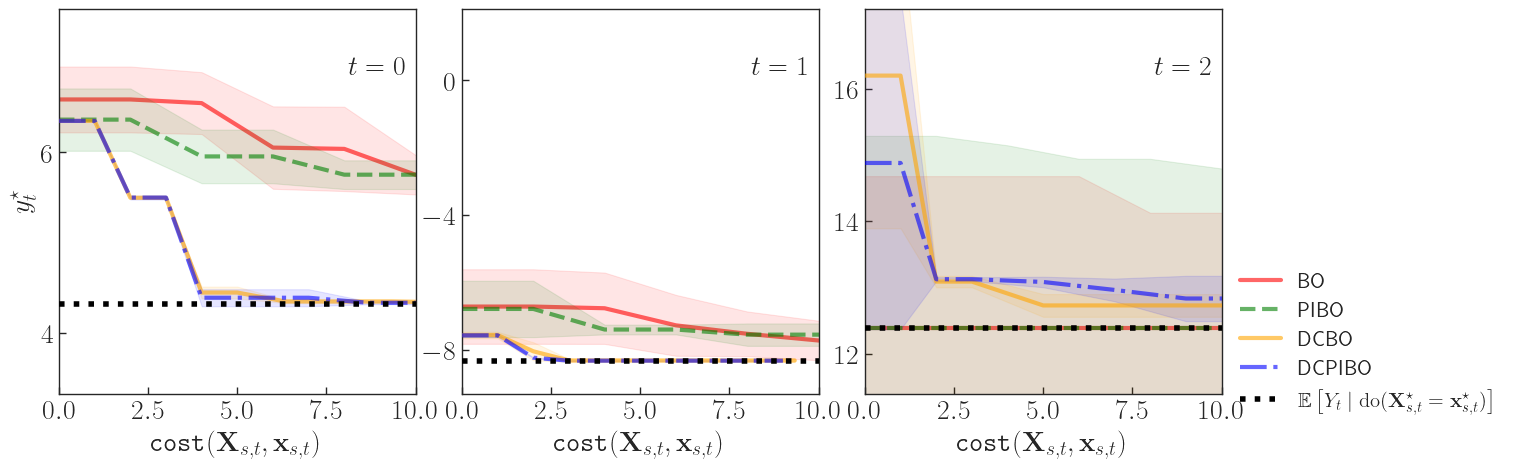

In [161]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    bad_exp_per_trial_cost,
    bad_exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))

### Very bad prior

In [132]:
# very_bad_data = get_relevant_results(results=very_bad_results,replicates=R)
# very_bad_exp_optimal_outcome_values_during_trials, very_bad_exp_per_trial_cost = elaborate(number_of_interventions=None, 
#                                                                          n_replicates=R, 
#                                                                          data=very_bad_data, 
#                                                                          best_objective_values=true_objective_values, 
#                                                                          T=T)

In [133]:
# # Each frame corresponds to one time-slice.
# plot_expected_opt_curve_paper(T,
#     true_objective_values,
#     very_bad_exp_per_trial_cost,
#     very_bad_exp_optimal_outcome_values_during_trials,
#     plot_params,  
#     fig_size = (15,5))

## Gap Metric

In [134]:
def compute_gap_values(T, summary):
    G_BO=0
    G_PIBO=0
    G_DCBO=0
    G_DCPIBO=0
    list_gaps=[]
    summary_list = list(summary.values())
    for i in range(len(summary_list)):
        for t in range(T):
            # print(summary_list[i][t][0])
            if i==0:
                G_BO=G_BO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_BO/T)
            elif i==1:
                G_PIBO=G_PIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_PIBO/T)
            elif i==2:
                G_DCBO=G_DCBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCBO/T)
            elif i==3:
                G_DCPIBO=G_DCPIBO+summary_list[i][t][0]
                if t==2:
                    list_gaps.append(G_DCPIBO/T)
    return list_gaps

### Good Gap Metric

In [135]:
good_t_i_l = get_common_initial_values(T=T,
                                  data=good_data,
                                  n_replicates=R)

good_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                           exp_optimal_outcome_values_during_trials=good_exp_optimal_outcome_values_during_trials,
                           n_trials=N,
                           T=T,
                           n_decimal=1)

good_summary = gap_metric_standard(T=T,
                             data=good_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = good_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=good_w_c_d)

good_list = compute_gap_values(T, good_summary)

In [136]:
good_summary

{'BO': [[0.28830436692188005, 0.0025708987080823756],
  [0.324359154639476, 0.15493955472804793],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.2754938743147116, 0.018878349447506295],
  [0.43315231152180683, 0.07954359298959245],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.5196363926005798, 0.0033041818918741737],
  [0.8947368421052632, 0.0],
  [0.4679024301678452, 0.06468624777629024]],
 'DCPIBO': [[0.6804383441348122, 0.0030544382010014135],
  [0.8915799902196931, 0.004464462750976099],
  [0.5112570532984495, 0.005310938499322425]]}

In [137]:
good_list

[0.5550983668362415,
 0.5870925882612956,
 0.6274252216245627,
 0.6944251292176515]

### Bad Gap Metric

In [162]:
bad_t_i_l = get_common_initial_values(T=T,
                                  data=bad_data,
                                  n_replicates=R)

bad_w_c_d = get_converge_trial(best_objective_values=true_objective_values,
                          exp_optimal_outcome_values_during_trials=bad_exp_optimal_outcome_values_during_trials,
                          n_trials=N,
                          T=T,
                          n_decimal=1)

bad_summary = gap_metric_standard(T=T,
                             data=bad_data,
                             best_objective_values=true_objective_values,
                             total_initial_list = bad_t_i_l,
                             n_replicates=R,
                             n_trials=N,
                             where_converge_dict=bad_w_c_d)

bad_list = compute_gap_values(T, bad_summary)

In [163]:
bad_summary

{'BO': [[0.23764936085011135, 0.03141878187508274],
  [0.4176338714898325, 0.15369944239748343],
  [1.0526315789473684, 0.0]],
 'PIBO': [[0.2574440802449292, 0.025643043079895494],
  [0.3857941613383738, 0.040433985423907234],
  [1.0526315789473684, 0.0]],
 'DCBO': [[0.7324558969025897, 0.004264938885178254],
  [0.8888359952414566, 0.008345057664281955],
  [0.44882423440765695, 0.10018588083770825]],
 'DCPIBO': [[0.6807160150426571, 0.0032525655417337397],
  [0.8946420136766454, 0.00013410764984968967],
  [0.4946565489152522, 0.02324968203770959]]}

In [164]:
bad_list

[0.5693049370957707,
 0.5652899401768905,
 0.6900387088505678,
 0.6900048592115183]